In [1]:
import numpy as np
import random 
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
class Bandit:
    
    def __init__(self, k):
        """
        k: number of bandits 
        """
        self.k = k
        self.mean_sd_list = [] # Storing mean and sf of each bandit
        
        max_mean = 0
        self.max_i = 0
        
        for i in range(k):
            mean = random.uniform(-1, 1)
            sigma = random.uniform(0, 2)
            self.mean_sd_list.append((mean, sigma))
            
            if mean > max_mean:
                max_mean = mean
                self.max_i = i
        
    def generate_reward(self, i):
        mu, sigma = self.mean_sd_list[i]
        return np.random.normal(mu, sigma)
    
    def generate_optimum_reward(self):
        return self.generate_reward(self.max_i)

In [4]:
class Solver(object):
    
    def __init__(self, bandit):
        """
        bandit(object of class Bandit) to solve
        """
        
        self.bandit = bandit
        
        self.counts = [0] * self.bandit.k
        self.actions = []
        self.cumulative_regret = 0
        self.cumulative_regret_list = []
        self.cumulative_reward = 0
        self.avg_reward_list = []
    
    def update_regret(self, r):
        self.cumulative_regret += self.bandit.generate_optimum_reward() - r
        self.cumulative_regret_list.append(self.cumulative_regret)
    
    def update_reward(self, r):
        self.cumulative_reward += r
        self.t = np.sum(self.counts)
        self.avg_reward_list.append(self.cumulative_reward / self.t)
        
    def run_one_step(self):
        pass
    
    def run(self, num_steps):
        for _ in range(num_steps):
            i, r = self.run_one_step()
            self.counts[i] += 1 
            self.update_regret(r)
            self.update_reward(r)
            self.actions.append(i)

    # Functions to average results over num_avg times        
    # Reset parameters
    def reinit(self):
        self.counts = [0] * self.bandit.k
        self.actions = []
        self.cumulative_regret = 0
        self.cumulative_regret_list = []
        self.cumulative_reward = 0
        self.avg_reward_list = []
        
    def avg_run(self, num_steps, num_avg):
        avg_list = [0] * num_steps
        for _ in range(num_avg):
            self.reinit()
            self.run(num_steps)
            for i in range(num_steps):
#                 avg_list[i] += self.avg_reward_list[i]
                avg_list[i] += self.cumulative_regret_list[i]
        
        avg_list = [x/num_avg for x in avg_list]
        return avg_list

In [5]:
class EpsilonGreedy(Solver):
    
    def __init__(self, bandit, epsilon, time_variant_epsilon, init_trials):
        super().__init__(bandit)
        self.bandit = bandit
        self.epsilon = epsilon
        self.time_variant_epsilon = time_variant_epsilon
        self.mean_estimate = [0] * self.bandit.k
        self.t = 0
        
        self.set_inital_estimate(init_trials)
#         print("Initial estimate = ", self.mean_estimate)
    
    def set_inital_estimate(self, trials):
        for _ in range(trials):
            for i in range(self.bandit.k):
                r = self.bandit.generate_reward(i)
                self.mean_estimate[i] = self.mean_estimate[i] + (r - self.mean_estimate[i])/(self.counts[i] + 1)

    def run_one_step(self):
        # Exploration
        if np.random.random() < self.epsilon:
            i = np.random.randint(0, self.bandit.k)
        # Exploitation
        else:
            # Pick the one with max probabilities
            i = max(range(self.bandit.k), key = lambda x: self.mean_estimate[x])
        
        r = self.bandit.generate_reward(i)
        self.mean_estimate[i] = self.mean_estimate[i] + (r - self.mean_estimate[i])/(self.counts[i] + 1)

        self.t += 1        
        if self.time_variant_epsilon:
            self.epsilon = self.epsilon/self.t

        return i, r

In [6]:
class UCB(Solver):

    def __init__(self, bandit):
        super().__init__(bandit)
        self.t = 0
        self.mean_estimate = [0] * self.bandit.k
        
#     def set_inital_estimate(self, trials):
#         for _ in range(trials):
#             for i in range(self.bandit.k):
#                 r = self.bandit.generate_reward(i)
#                 self.mean_estimate[i] = self.mean_estimate[i] + (r - self.mean_estimate[i])/(self.counts[i] + 1)

    def run_one_step(self):
        # Exploration
        i = max(range(self.bandit.k), key = lambda x: self.mean_estimate[x] + self.bandit.mean_sd_list[x][1] * np.sqrt(2 * np.log(self.t + 1)/ self.counts[x]))
        
        r = self.bandit.generate_reward(i)
        self.mean_estimate[i] = self.mean_estimate[i] + (r - self.mean_estimate[i])/(self.counts[i] + 1)

        self.t += 1        
        return i, r

In [8]:
# Launch the tensorflow graph
class PolicyGradient(Solver):
    
    def __init__(self, bandit, episodes = 100, epsilon = 0.3):
        super().__init__(bandit)
        tf.reset_default_graph()

        self.epsilon = epsilon
        self.bandit = self.bandit
        self.num_bandits = self.bandit.k
        self.lr = 0.001
        self.alpha = 0.001 
        self.episodes = episodes
        
        self.current_count = 0
        self.bandits_chosen = []
        self.reward_list = []


        
# Launch the tensorflow graph

    def run_all(self):
#         print("here")
        tf.reset_default_graph()
        
        # Initial weights and action
        weights = tf.Variable(tf.ones([self.num_bandits]))
        # print("Initial weights", weights)

        chosen_action = tf.argmax(weights, 0)
        # print("Action:", chosen_action)

        # reward_holder = tf.placeholder(shape=[1],dtype=tf.float32)
        advantage_holder = tf.placeholder(shape=[1],dtype=tf.float32)
        action_holder = tf.placeholder(shape=[1],dtype=tf.int32)

        responsible_weight = tf.slice(weights, action_holder, [1])
        # Loss function and update
        loss = -(tf.log(responsible_weight) *  advantage_holder)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = self.lr)
        update = optimizer.minimize(loss)
        
        total_reward = np.zeros(self.num_bandits)
        
        init = tf.initialize_all_variables()
        
        with tf.Session() as sess:
            sess.run(init)
            i = 0 
            while i < self.episodes:
                # Choose action using e-greedy
                if np.random.rand(1) < self.epsilon:
                    action = np.random.randint(self.num_bandits)
                else:
                    action = sess.run(chosen_action)

                reward = self.bandit.generate_reward(action)
                total_reward[action] += reward
                avg_reward = np.mean(total_reward)
                advantage = reward - avg_reward

                #  Update the network.
                new_update, resp_weight, updated_weights = sess.run([update, responsible_weight, weights], feed_dict={advantage_holder:[advantage], action_holder:[action]})

                self.bandits_chosen.append(action)
                self.reward_list.append(reward)
                
                # if i % 50 == 0:
                #     print("Running reward for the " + str(num_bandits) + " bandits: " + str(total_reward))
                i += 1
    
    def run_one_step(self):
        if self.current_count == 0:
            self.run_all()
        
        bandit, reward = self.bandits_chosen[self.current_count], self.reward_list[self.current_count]
        self.current_count += 1
#         print(self.current_count, bandit, reward)
        return bandit, reward

In [9]:
def main(k, n):
    """
    k = number of bandits
    n = time steps
    """
    
    # defining object of class Bandit 
    bandit = Bandit(k) 
    print("Guassian distribution of bandits = \n", bandit.mean_sd_list)
    
    solvers = [
               EpsilonGreedy(bandit, epsilon = 0.1, init_trials = 1, time_variant_epsilon = True), 
               UCB(bandit),
               PolicyGradient(bandit, episodes = n, epsilon = 0.3)
              ]
    
    # Solve for each of the object
    for s in solvers:
        s.run(n)
    
    # Plot average reward for each solver
    plt.figure(figsize = (10, 8))
    colors = ['k', 'b', 'r', 'y']
    labels = ['Epsilon = 0.1 (time variant)', 'UCB', 'PolicyGradient']
    i = 0
    for s in solvers:
        plt.plot(s.avg_reward_list, color = colors[i], label = labels[i])
        i += 1

    plt.xlabel("Steps")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.title("Average Reward vs steps for {} bandits".format(k))
    plt.show()
    
    
    # Plot cumulative regret for each solver
    plt.figure(figsize = (10, 8))
    i = 0
    for s in solvers:
        plt.plot(s.cumulative_regret_list, color = colors[i], label = labels[i])
        i += 1

    plt.xlabel("Steps")
    plt.ylabel("Cumulative Regret")
    plt.legend()
    plt.title("Cumulative regret vs steps for {} bandits".format(k))
    plt.show()

Guassian distribution of bandits = 
 [(0.2939164025712997, 0.8564877701891693), (0.2235213804083811, 0.2951394026326406), (-0.9896579825790712, 1.2704389340688043), (0.9144733502527818, 0.7078970019837019), (-0.3369005717637257, 1.981315230319848), (0.517068365499705, 1.0814691288914724), (-0.3441590464353299, 1.4595575766580735), (-0.12408971616497566, 0.26823159254041506)]
Instructions for updating:
Use `tf.global_variables_initializer` instead.


/Users/keyadesai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/Users/keyadesai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


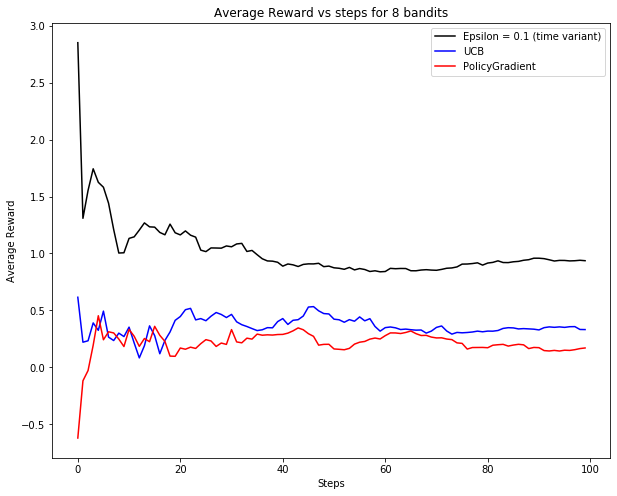

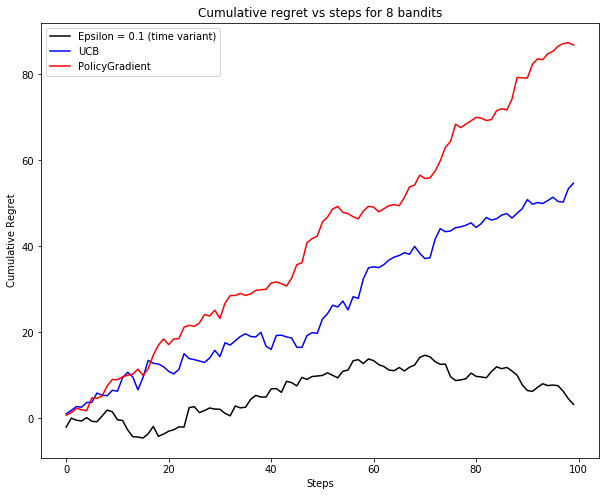

In [10]:
main(k = 8, n = 100)

## Taking average over 10 steps

In [13]:
def experiment(k, n, avg_over):
    bandit = Bandit(k)
    print("Guassian distribution of bandits = \n", bandit.mean_sd_list)
    
    colors = ['k', 'b', 'r', 'y']
    labels = ['Epsilon = 0.1 (time variant)', 'UCB', 'PolicyGradient']
    solvers = [EpsilonGreedy(bandit, epsilon = 0.1, init_trials = 1, time_variant_epsilon = True), 
               UCB(bandit),
               PolicyGradient(bandit, episodes = n * avg_over, epsilon = 0.3)
            ]
    
    avg_list = []
    
    for s in solvers:
        l = s.avg_run(n, avg_over) # returns avg cumulative regret over n steps
        avg_list.append(l)
        
    plt.figure(figsize = (10, 8))
    for i, l in enumerate(avg_list):
        plt.plot(l, color = colors[i], label = labels[i])

    plt.xlabel("Steps")
    plt.ylabel("Cumulative Regret")
    plt.legend()
    plt.title("Cumulative regret vs steps for {} bandits (Averaged over {} tasks)".format(k, avg_over))
    plt.show()
    
#     plt.figure(figsize = (10, 8))
#     i = 0
#     for s in solvers:
#         plt.plot(s.cumulative_regret_list, color = colors[i], label = labels[i])
#         i += 1

#     plt.xlabel("Steps")
#     plt.ylabel("Cumulative Regret")
#     plt.legend()
#     plt.title("Cumulative regret vs steps for {} bandits (Averaged over {} tasks)".format(k, avg_over))
#     plt.show()

Guassian distribution of bandits = 
 [(-0.6058187125815631, 0.39619853224334545), (-0.3722824858915703, 1.2612811900782555), (-0.5391893568249271, 0.14244418238328604), (-0.6460962683883709, 0.4786669378370223), (-0.5814266793549094, 1.2537832581017927), (-0.40373693007973976, 0.25679005229387486), (-0.08623228016174078, 0.7905126791444816), (0.4949108189659486, 0.9488666175062184)]


/Users/keyadesai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/Users/keyadesai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


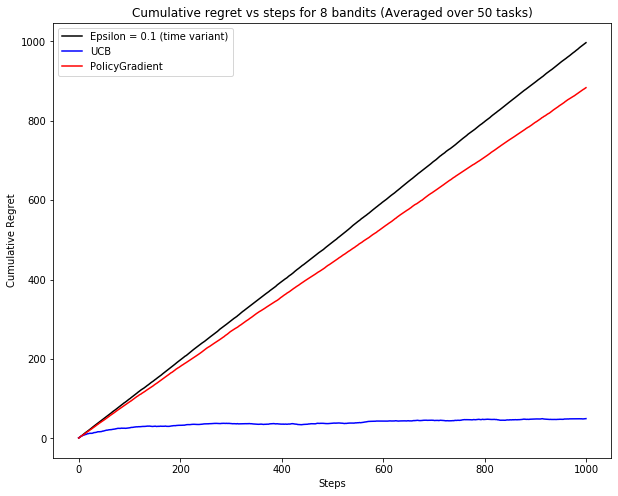

In [15]:
experiment(k = 8, n = 1000, avg_over = 50)